In [1]:
import os
import numpy as np
import sys
import zipfile
import json
import pandas as pd
import matplotlib.pyplot as plt

DATA = '../data/example.zip'

try:
    import tifffile as tf
except ImportError:
    print('Installing tifffile package ...')
    os.system("pip install tifffile")
    print('Done!')
    import tifffile as tf

In [2]:
# Read directly from the zip file
zf = zipfile.ZipFile(DATA)
with zf.open('analyzed_data.csv') as file:
    df = pd.read_csv(file, index_col=0)

with zf.open('primary_vids/Experiment Info/experiment_info.json') as file:
    exp_info = json.load(file)
    
df.head() 

,t,Incident_flux,xy0t0,xy0t0_valid_only,exp_times,exp_times_valid_only,xy0t0_cts,xy0t0_cts_valid_only,PLQY_xy0t0,PLQY_xy0t0_valid_only,...,frame_corrupted,Index,DC LD [nm],Low Freq LD [nm],High Freq LD [nm],Transmitted Power [W],DC LD [norm],Low Freq LD [norm],High Freq LD [norm],Transmitted Power [norm]
0.0,0.0,1.250000e+22,2.130000e+17,2.130000e+17,0.0,0.0,2.130000e+16,2.130000e+16,0.000017,0.000017,...,False,0.0,82.194489,80.966546,80.111765,0.000002,1.000000,1.000000,1.000000,1.000000
1.0,300.0,1.250000e+22,1.360000e+18,1.360000e+18,0.0,0.0,1.360000e+17,1.360000e+17,0.000109,0.000109,...,False,1.0,106.274299,102.874487,102.674620,0.000002,1.292961,1.270580,1.281642,1.070749
2.0,600.0,1.250000e+22,6.260000e+18,6.260000e+18,0.0,0.0,6.270000e+17,6.270000e+17,0.000501,0.000501,...,False,2.0,125.711414,123.903528,121.923113,0.000002,1.529438,1.530305,1.521913,1.164229
3.0,900.0,1.250000e+22,1.190000e+19,1.190000e+19,0.0,0.0,1.190000e+18,1.190000e+18,0.000950,0.000950,...,False,3.0,140.087781,135.428144,134.067284,0.000003,1.704345,1.672643,1.673503,1.257022
4.0,1200.0,1.250000e+22,1.550000e+19,1.550000e+19,0.0,0.0,1.550000e+18,1.550000e+18,0.001237,0.001237,...,False,4.0,154.990586,152.282351,149.307247,0.000003,1.885657,1.880806,1.863737,1.355720


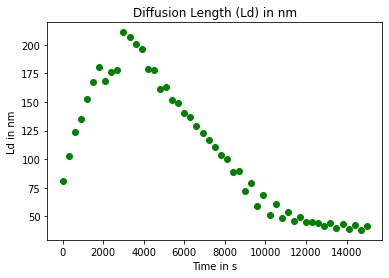

In [3]:
plt.scatter(df['t'], df['Low Freq LD [nm]'], c='green');
plt.xlabel('Time in s')
plt.ylabel('Ld in nm')
plt.title('Diffusion Length (Ld) in nm');

In [4]:
def get_PL_image(time):

    """
    Returns the image array when an integer time point is passed.
    
    Parameters
    -------------------
    time : int
        The time point of the PL image is to be loaded
        
    Returns
    -------------------
    numpy.ndarray
        The 2D array of the PL image
    
    """
    exp_name = exp_info['ExperimentID']
    image_path = '/'.join(['primary_vids', exp_name + '_grad0_loc0_time' + str(time), 'MMStack_Pos0.ome.tif'])
    
    # read the tiff image stack
    with zf.open(image_path) as file:
        img_stack = tf.imread(file)
     
    # Reorder axes to make it scikit-image compatible
    if len(img_stack.shape)>2:
        img_stack = np.swapaxes(img_stack,0,2)
        img_stack = np.swapaxes(img_stack,0,1)
    
    # If a regular 2D image, just return it
    if len(img_stack.shape)<3:
        return img_stack
    
    # Return the mean of pixels along the stacking axis
    return np.mean(img_stack, axis=2)

Text(0.5, 1.0, 'PL image at time point 0')

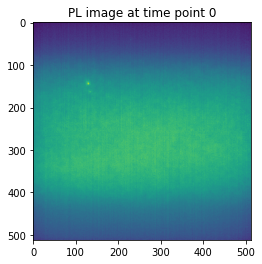

In [5]:
time = 0
img = get_PL_image(time)
plt.imshow(img)
plt.title('PL image at time point ' + str(time))

# Average over the first five images

In [12]:
#Averaging first five images
img0 = get_PL_image(0)
img1 = get_PL_image(1)
img2 = get_PL_image(2)
img3 = get_PL_image(3)
img4 = get_PL_image(4)
img_all = np.array([img0,img1,img2,img3,img4])


img_avg = np.average(img_all,axis=0)
img_avg

array([[2082.844, 2096.924, 2116.036, ..., 2067.352, 2065.352, 2075.908],
       [2123.62 , 2145.272, 2123.828, ..., 2107.792, 2114.108, 2094.908],
       [2145.116, 2146.176, 2156.192, ..., 2109.348, 2107.656, 2100.52 ],
       ...,
       [2127.744, 2173.14 , 2164.476, ..., 2103.528, 2137.552, 2094.38 ],
       [2143.388, 2140.012, 2165.628, ..., 2103.352, 2116.104, 2070.708],
       [2138.24 , 2126.988, 2110.208, ..., 2080.932, 2068.248, 2071.532]])

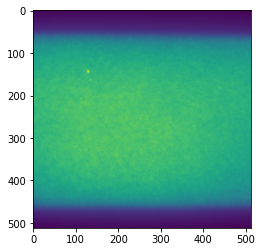

In [13]:
plt.imshow(img_avg)

In [65]:
def compress_img(n, img):
    new_img = list()
    og_size = img.shape[0]
    img = list(img)
    
    
    for i in range(len(img)):
        if i % n == 0:
            for j in range(len(img)):
                if j % n == 0:
                    new_img.append(img[i][j])
                 
    new_img = np.array(new_img)
    new_img = new_img.reshape(int(og_size / n) , int(og_size / n))
    
    return new_img

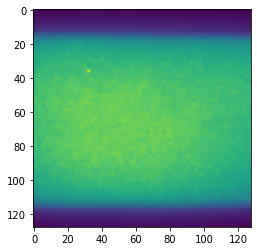

In [66]:
new_img1 = compress_img(4,img_avg)
plt.imshow(new_img1)

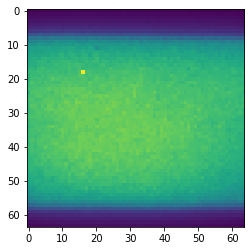

In [70]:
new_img2 = compress_img(8,img_avg)
plt.imshow(new_img2)

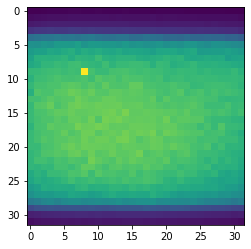

In [69]:
new_img3 = compress_img(16,img_avg)
plt.imshow(new_img2)

# Build an AutoEncoder

In [14]:
import keras
from keras import layers

In [72]:
new_img3 = new_img3.flatten()
new_img3.shape

(1024,)

In [73]:
encoding_dim = 1024  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(1024,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(1024, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

encoder = keras.Model(input_img, encoded)

In [74]:
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [76]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')